In [27]:
%matplotlib inline
from vizwiz_api.vizwiz import VizWiz
from vizwiz_eval_cap.eval import VizWizEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import pylab
#pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

ModuleNotFoundError: No module named 'wordcloud'

In [2]:
# download Stanford models
#!bash get_stanford_models.sh # for Windows with Windows Subsystem for Linux (WSL) installed
! ./get_stanford_models.sh   # for Linux / MacOS

Found Stanford CoreNLP.


In [3]:
# file containing groundtruth
annFile = './annotations/train.json'

In [4]:
# initialize VizWiz API for groundtruth 
vizwiz = VizWiz(annFile, ignore_rejected=True, ignore_precanned=True)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created! imgs = 23431, anns = 100575


In [5]:
# vizualizing dataset data
anns_ids = vizwiz.anns.keys()
for ann_id in anns_ids:
    print(vizwiz.anns[ann_id])
    if ann_id > 5:
        break

{'caption': 'ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.', 'image_id': 0, 'is_precanned': False, 'is_rejected': False, 'id': 0, 'text_detected': True}
{'caption': 'A green and white plastic condiment bottle containing Basil leaves.', 'image_id': 0, 'is_precanned': False, 'is_rejected': False, 'id': 1, 'text_detected': True}
{'caption': 'A bottle of spices in a plastic container laying on a surface.', 'image_id': 0, 'is_precanned': False, 'is_rejected': False, 'id': 3, 'text_detected': True}
{'caption': 'some basil leaves in a container on a counter', 'image_id': 0, 'is_precanned': False, 'is_rejected': False, 'id': 4, 'text_detected': True}
{'caption': 'A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.', 'image_id': 1, 'is_precanned': False, 'is_rejected': False, 'id': 5, 'text_detected': True}
{'caption': 'A black can of Coca Cola Zero calorie soda is on the counter near the coffee maker.', 'image_id': 1, 'is_precanned': False, 'is_

In [6]:
#create captions list
captions = []
for ann_id in anns_ids:
    captions.append(vizwiz.anns[ann_id]['caption'])

In [16]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [25]:
# create clean vocabulary
import nltk
import re
#nltk.download('stopwords')
#nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from collections import Counter

stopwords = stopwords.words('english')

clean_vocabulary= []
clean_caps = []

for caption in captions:
    caption =  re.sub(r'[^\w\s]', '', str(caption).lower().strip())
    capt_tks = caption.split()
    #remove stopwords
    capt_tks = [word for word in capt_tks if word not in 
                    stopwords]
    #stemming , removes sufixes
    ps = nltk.stem.porter.PorterStemmer()
    capt_tks = [ps.stem(word) for word in capt_tks]
    
    #lematize text
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    capt_tks = [lem.lemmatize(word) for word in capt_tks]
    #back to string
    clean_cap = "".join(capt_tks)
    clean_caps.append(clean_cap)
    

[nltk_data] Downloading package omw-1.4 to /home/adrobut/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [28]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.1/366.1 KB 2.4 MB/s eta 0:00:0000:0100:01


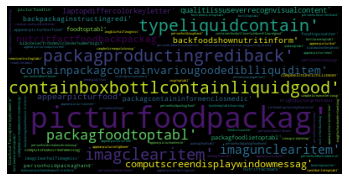

In [30]:
import wordcloud
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(clean_caps))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [32]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 9.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 KB 5.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 2.0 MB/s eta 0:00:00a 0:00:01


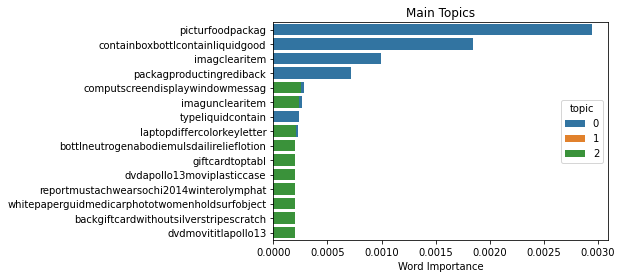

In [39]:
import gensim.downloader as gensim_api
import gensim
import pandas as pd
import seaborn as sns

nlp = gensim_api.load("glove-wiki-gigaword-300")


lst_corpus = []
for string in clean_caps:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)
## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)
## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 
## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])
    
## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

In [40]:
!pip install nbconvert
